<a href="https://colab.research.google.com/github/MNabegh/mlbd-project/blob/master/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


In [2]:
!ls

drive  lastfm-dataset-1K  lastfm-dataset-1K.tar.gz  sample_data


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls drive/MyDrive/data

feature_df_with_emb_clean.csv  spotify_features_cleaned.csv
feature_df_with_emb.csv        spotify_features.csv
genres_3d_mapping.json


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [6]:
path = "drive/MyDrive/data/feature_df_with_emb_clean.csv"

feature_df_with_emb = pd.read_csv(path)
feature_df_with_emb = feature_df_with_emb.drop(columns=['Unnamed: 0', 'genres', 'genres_emb'])
feature_df_with_emb = feature_df_with_emb.dropna()

In [7]:
feature_df_with_emb.head()

,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,emb_x,emb_y,emb_z
0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794,0.1130,0.5290,105.089,330253.0,62,7.375277,4.894493,0.943493
1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916,0.1140,0.2700,137.802,540133.0,62,7.375277,4.894493,0.943493
2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939,0.1010,0.0703,73.926,216853.0,39,7.375277,4.894493,0.943493
3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859,0.0866,0.0376,80.714,384707.0,62,7.375277,4.894493,0.943493
4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898,0.1030,0.0920,104.191,580707.0,62,7.375277,4.894493,0.943493


In [8]:
feature_df_with_emb.isna().sum()

artist              0
track               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
popularity          0
emb_x               0
emb_y               0
emb_z               0
dtype: int64

In [9]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [10]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [11]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [12]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [13]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [14]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [15]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [16]:
df = df.set_index('song-id')

In [17]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [18]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [19]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [20]:
matrix_init = matrix_init['timestamp']
matrix_init = matrix_init.map(lambda x: np.log(x))

In [21]:
matrix_init = matrix_init.reset_index()

In [22]:
def rating_scaler(row):
    row_array = np.array(row)
    lower_bound, new_range= 3, 7
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + lower_bound
    scaled_row[scaled_row == 3] = 0
    return pd.Series(scaled_row)

In [23]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [24]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [25]:
matrix_init['timestamp'].describe()

count    4.613822e+06
mean     2.817463e+00
std      2.828400e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.937382e+00
75%      5.201265e+00
max      9.999999e+00
Name: timestamp, dtype: float64

In [26]:
(matrix_init['timestamp'] == 0).sum() / matrix_init.shape[0]

0.47684197613171897

In [27]:
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[0]+'-'+row[1], axis=1)

### Merge data

In [28]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

In [29]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [30]:
matrix_extended.head()

,user,artist,track,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,4.142058,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,2562-Basin Dub
1,user_000451,2562,Basin Dub,4.080958,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,2562-Basin Dub
2,user_000471,2562,Basin Dub,0.000000,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,2562-Basin Dub
3,user_000508,2562,Basin Dub,4.976012,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,2562-Basin Dub
4,user_000515,2562,Basin Dub,3.973598,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,2562-Basin Dub


### Filter the dataset

In [31]:
matrix_extended.groupby('user').count()['rating'].describe()

count      991.000000
mean      3901.116044
std       4556.333601
min          3.000000
25%       1128.000000
50%       2654.000000
75%       4951.000000
max      58844.000000
Name: rating, dtype: float64

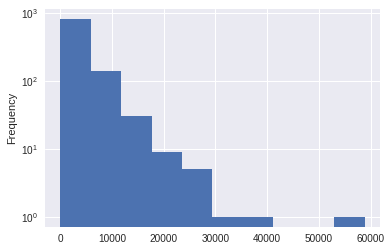

In [32]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [33]:
matrix_extended.groupby('item').count()['rating'].describe()

count    750791.000000
mean          5.149244
std          11.747020
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

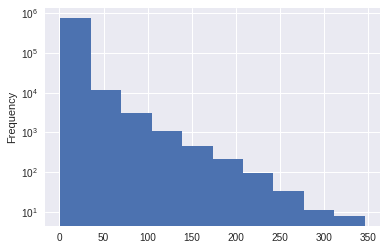

In [34]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

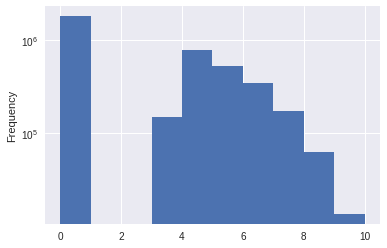

In [234]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [36]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [37]:
matrix_sampled.groupby('user').count()['rating'].describe()

count      991.000000
mean      3130.442987
std       3484.796843
min          3.000000
25%        972.000000
50%       2182.000000
75%       3987.000000
max      44191.000000
Name: rating, dtype: float64

### Sample Users

In [38]:
# no_users = 200
# users_list = matrix_extended.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled = matrix_extended.copy()
# matrix_sampled = matrix_sampled.set_index('user')
# matrix_sampled = matrix_sampled.loc[users_sampled]
# matrix_sampled = matrix_sampled.reset_index()
# matrix_sampled = matrix_sampled.sample(frac=1)
# matrix_sampled['item'] = matrix_sampled.apply(lambda row: row[1]+'-'+row[2], axis=1)

In [39]:
matrix_sampled.head()

,item,user,artist,track,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,emb_x,emb_y,emb_z
24910,A Silver Mt. Zion-13 Angels Standing Guard 'Ro...,user_000793,A Silver Mt. Zion,13 Angels Standing Guard 'Round The Side Of Yo...,4.512691,0.115,0.303,11.0,-13.693,0.0,0.0403,0.96700,0.852000,0.0611,0.039,79.193,442293.0,43,6.522470,6.943111,1.138192
1450841,Lisa Ekdahl-Papillas Samba,user_000522,Lisa Ekdahl,Papillas Samba,4.748770,0.607,0.316,4.0,-11.665,0.0,0.0298,0.65900,0.000095,0.1230,0.495,109.874,142267.0,53,7.325242,7.102291,2.345108
983376,Garbage-Temptation Waits,user_000727,Garbage,Temptation Waits,6.004588,0.560,0.876,9.0,-8.183,1.0,0.0435,0.00103,0.014000,0.5510,0.559,127.921,276604.0,64,4.901899,8.086782,1.545952
1272802,Jonas Brothers-Pushin' Me Away,user_000894,Jonas Brothers,Pushin' Me Away,0.000000,0.473,0.903,7.0,-6.123,1.0,0.0678,0.01450,0.000001,0.1950,0.452,161.956,183120.0,80,5.049340,7.546886,3.666668
2622497,The Futureheads-Robot,user_000467,The Futureheads,Robot,0.000000,0.433,0.956,9.0,-2.928,1.0,0.1430,0.23100,0.000000,0.0809,0.818,161.485,120973.0,48,5.688332,7.747486,1.911682


In [40]:
matrix_sampled['user_id'] = matrix_sampled['user'].astype('category').cat.codes
matrix_sampled['item_id'] = matrix_sampled['item'].astype('category').cat.codes

In [233]:
from random import choices
indices_to_upsample = matrix_sampled.index[matrix_sampled['rating'] > 8].tolist()
indices_upsampled = choices(indices_to_upsample, k=len(indices_to_upsample) * 5)
samples_df = matrix_sampled.loc[indices_upsampled]
matrix_sampled = pd.concat([matrix_sampled, samples_df], axis=0)

In [235]:
X = matrix_sampled[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled['rating']
groups = matrix_sampled['user_id']

In [236]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [237]:
no_users, no_items, no_factors = matrix_sampled['user_id'].nunique(), matrix_sampled['item_id'].nunique(), 100

In [238]:
no_users

991

In [239]:
no_items

217058

In [240]:
X.shape

(3439054, 14)

### Models

In [241]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [242]:
model = create_shallow_model(no_factors, no_users, no_items)

In [243]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       99200       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       21705900    item_id[0][0]                    
______________________________________________________________________________________

In [244]:
def create_deep_model(no_factors, no_users, no_items):
    all_input = tf.keras.layers.Input(shape=[14], name='input')
    input_reshaped = tf.keras.layers.Reshape((14,1), input_shape=(14,))(all_input)

    # Process input
    user_id_vec = tf.keras.layers.Cropping1D(cropping=(0,13))(input_reshaped)
    user_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(user_id_vec)

    item_id_vec = tf.keras.layers.Cropping1D(cropping=(1,12))(input_reshaped)
    item_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(item_id_vec)
    # User branch
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(64,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(32,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(16,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(8,name='fc6', activation='relu')(dropout_3)
    dense_4_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_4)
    # Model definition
    model = tf.keras.models.Model(inputs=[all_input], outputs=[dense_4_output], name='deep_model')
    return model

In [245]:
def create_deep_hybird_model(no_factors, no_users, no_items):
    all_input = tf.keras.layers.Input(shape=[14], name='input')
    input_reshaped = tf.keras.layers.Reshape((14,1), input_shape=(14,))(all_input)

    # Process input
    user_id_vec = tf.keras.layers.Cropping1D(cropping=(0,13))(input_reshaped)
    user_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(user_id_vec)

    item_id_vec = tf.keras.layers.Cropping1D(cropping=(1,12))(input_reshaped)
    item_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(item_id_vec)

    metadata_vec = tf.keras.layers.Cropping1D(cropping=(2,0))(input_reshaped)
    metadata = tf.keras.layers.Reshape((12,), input_shape=(12,1))(metadata_vec)

    # User branch
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Preprocess metadata
    dense_meta_1 = tf.keras.layers.Dense(12,name='fc1')(metadata)
    dense_meta_2 = tf.keras.layers.Dense(8,name='fc2')(dense_meta_1)
    # Metadata concat
    vectors_concat_meta = tf.keras.layers.Concatenate() ([vectors_concat_dropout, dense_meta_2])
    # Backbone 
    dense_1 = tf.keras.layers.Dense(256,name='fc3')(vectors_concat_meta)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(128,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(64,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(32,name='fc6', activation='relu')(dropout_3)
    dropout_4 = tf.keras.layers.Dropout(0.2,name='d6')(dense_4)
    dense_5 = tf.keras.layers.Dense(16,name='fc7', activation='relu')(dropout_4)
    dropout_5 = tf.keras.layers.Dropout(0.2,name='d7')(dense_5)
    dense_6 = tf.keras.layers.Dense(8,name='fc8', activation='relu')(dropout_5)    
    dense_6_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_6)
    # Model definition
    model = tf.keras.models.Model(inputs=[all_input], outputs=[dense_6_output], name='deep_model')
    return model

In [246]:
model = create_deep_model(no_factors, no_users, no_items)

In [247]:
model = create_deep_hybird_model(no_factors, no_users, no_items)
model.summary()

Model: "deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 14)]         0                                            
__________________________________________________________________________________________________
reshape_57 (Reshape)            (None, 14, 1)        0           input[0][0]                      
__________________________________________________________________________________________________
cropping1d_42 (Cropping1D)      (None, 1, 1)         0           reshape_57[0][0]                 
__________________________________________________________________________________________________
cropping1d_43 (Cropping1D)      (None, 1, 1)         0           reshape_57[0][0]                 
_________________________________________________________________________________________

### Model training

In [ ]:
# Input-output data definition
 
# X_train_arr = X_train.values.tolist()
# Try a decaying learning rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1500,
    decay_rate=0.9)

opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.2)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)

# Model training
model.fit(X_train, y_train, epochs=10, callbacks=[callback], batch_size=2048, shuffle=True)

Epoch 1/10
1344/1344 [==============================] - 122s 90ms/step - loss: 8.4045
Epoch 2/10
1344/1344 [==============================] - 121s 90ms/step - loss: 7.4983
Epoch 3/10
1344/1344 [==============================] - 121s 90ms/step - loss: 6.9861
Epoch 4/10
 669/1344 [=============>................] - ETA: 1:01 - loss: 6.6058

### Prediction

In [249]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train, batch_size=2048)

In [250]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
2904986,861,201833,0.286,0.990,0.0989,0.000137,0.000160,0.0926,0.4840,147.369,51,5.559157,8.241899,0.516022
831948,95,59829,0.647,0.582,0.0755,0.410000,0.000002,0.0715,0.9150,167.396,81,4.614431,7.214665,0.552928
2083922,606,148197,0.556,0.913,0.0437,0.019300,0.000009,0.3460,0.7300,96.184,86,5.475037,7.888066,1.189500
1698045,629,125004,0.420,0.691,0.0501,0.310000,0.042700,0.1090,0.0383,115.326,80,5.511852,7.928967,1.565430
1673946,521,123074,0.489,0.913,0.0406,0.007690,0.001600,0.2240,0.7250,129.911,65,5.608908,7.759831,1.461241


In [253]:
# Predictions in the test set
# X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test, batch_size=2048)

### Evaluation

In [254]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

Train RMSE: 2.7295899099986802
Test RMSE: 2.8355140902937634


In [258]:
def get_test_predictions(model, X_test):
  predictions_li = []
  for user_id, test_user in tqdm(X_test.groupby('user_id'), position=0, leave=True):    
    # Retrieve the unseen items
    user_df = test_user[['item_id', 'rating']].copy()
    test_pids = user_df['item_id'].values
    relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
    if len(relevant_pids) == 0:
      continue
    # Make rating predictions for all items for that user
    predictions = model.predict(test_user.drop(columns=['rating']), batch_size=2048)
    # predictions = pred_func(model, user_id, pid_array, train_ratings)
    predictions = predictions.reshape(-1)
    irrelevant_pids = set(test_pids).difference(relevant_pids)
    predictions_relevant = predictions[user_df['rating'] > 2]
    predictions_irrelevant = predictions[user_df['rating'] == 0]
    predictions_dict = {'user_id': user_id,
                        'predictions': predictions,
                        'test_pids': test_pids,
                        'relevant_pids': relevant_pids,
                        'irrelevant_pids': irrelevant_pids,
                        'predictions_relevant': predictions_relevant,
                        'predictions_irrelevant': predictions_irrelevant}
    predictions_li.append(predictions_dict)

  return pd.DataFrame(predictions_li)


In [259]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
2904986,861,201833,0.286,0.990,0.0989,0.000137,0.000160,0.0926,0.4840,147.369,51,5.559157,8.241899,0.516022
831948,95,59829,0.647,0.582,0.0755,0.410000,0.000002,0.0715,0.9150,167.396,81,4.614431,7.214665,0.552928
2083922,606,148197,0.556,0.913,0.0437,0.019300,0.000009,0.3460,0.7300,96.184,86,5.475037,7.888066,1.189500
1698045,629,125004,0.420,0.691,0.0501,0.310000,0.042700,0.1090,0.0383,115.326,80,5.511852,7.928967,1.565430
1673946,521,123074,0.489,0.913,0.0406,0.007690,0.001600,0.2240,0.7250,129.911,65,5.608908,7.759831,1.461241


In [260]:
# X_test_arr = np.array(X_test_arr)
# test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})
X_test_copy = X_test.copy()
X_test_copy['rating'] = y_test 
predictions_df = get_test_predictions(model, X_test_copy)

100%|██████████| 990/990 [01:17<00:00, 12.83it/s]


In [261]:
def plot_predictions(predictions_df):
  pred_arr = [predictions_df[['predictions_relevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1),
              predictions_df[['predictions_irrelevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1)]

  f, ax = plt.subplots(1, 1)
  ax.set_title('Predictions distribution', color='C0')
  c = 'red'
  bplot = plt.boxplot(pred_arr, labels=['Relevant', 'Irrelevant'], vert=True, patch_artist=True)
  # fill with colors
  colors = ['C4', 'C2']
  for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

  for median in bplot['medians']:
    median.set(color='k', linewidth=1.5)

  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


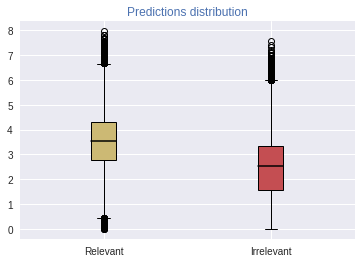

In [262]:
plot_predictions(predictions_df)

In [269]:
def precision_at_k(predictions_df):
    precisions = []
    # For each user
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      # Sort the items and het the top k
      top_k = predictions > 3
      if top_k.sum() == 0:
         precisions.append(0)
         continue
      top_k_items = set(np.array(test_pids)[top_k])
      # Compute precision as per definition
      precisions.append(len(top_k_items & relevant_pids) / top_k.sum())
    return precisions

In [270]:
precisions = precision_at_k(predictions_df)

In [271]:
np.mean(precisions), np.std(precisions)

(0.5364706514363914, 0.19839365576624188)

In [272]:
### EXERCISE CELL ###
def recall_at_k(predictions_df):
    recalls = []
    # For each user
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      # Sort the items and het the top k
      top_k = predictions > 2.5
      if top_k.sum() == 0:
         recalls.append(0)
         continue
      top_k_items = set(np.array(test_pids)[top_k])
      recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [273]:
recalls = recall_at_k(predictions_df)

In [274]:
np.mean(recalls), np.std(recalls)

(0.6942924224989347, 0.30920508696289856)

In [275]:
### EXERCISE CELL ###
def map_at_k(predictions_df, k=100):
    maps = []
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      partial_maps = []
      top_k = list(np.argsort(predictions)[:k])
      top_k_items = np.array(test_pids)[top_k]
      for rank, item_id in enumerate(top_k_items):
          if item_id in relevant_pids:
              partial_maps.append(len(set(top_k_items[:rank+1]) & relevant_pids) / float(rank+1))
      maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [276]:
maps = map_at_k(predictions_df, k=100)

In [277]:
np.mean(maps), np.std(maps)

(0.22431068112537797, 0.18257718739644627)